In [73]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [74]:
game_df = pd.read_csv("../data/game_info.csv")
game_df.head(1)

,id,rank,name,short_description,avg_rating,num_ratings,thumbnail_url,long_description,complexity_socre,year_published,image_url,min_play_time,max_play_time,expected_play_time
0,224517,1.0,Brass: Birmingham,"Build networks, grow industries, and navigate ...",8.62,37652,https://cf.geekdo-images.com/x3zxjr-Vw5iU4yDPg...,Brass: Birmingham is an economic strategy game...,3.8978,2018.0,https://cf.geekdo-images.com/x3zxjr-Vw5iU4yDPg...,60.0,120.0,120.0


In [75]:
print(f"{len(game_df)} games in total")
game_df = game_df[game_df['long_description'].isna()==False].reset_index()
print(f"{len(game_df)} games have a description")

2499 games in total
2426 games have a description


In [76]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df=1, stop_words='english')
tfidf_matrix = tf.fit_transform(game_df['long_description'])
cos_sim_tfidf = cosine_similarity(tfidf_matrix)

In [77]:
def get_top_recs(game_id=None, game_name=None, num_recs = 30):
    if game_id is None and game_name is None:
        print("Need to provide game_id or game_name")
        return
    if game_id is not None:
        idx = game_df.loc[game_df['id']==game_id, "name"].index.values[0]
    else:
        idx = game_df.loc[game_df['name']==game_name, "name"].index.values[0]

    sim_scores = list(enumerate(cos_sim_tfidf[idx]))
    top_recs = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:num_recs+1]
    rec_idxs = [rec[0] for rec in top_recs]
    rec_weights = [rec[1] for rec in top_recs]
    recs_df = pd.DataFrame({
        "source_name": game_df.loc[idx, 'name'],
        "source_id": game_df.loc[idx, 'id'],
        "edge_type": "similarTo",
        "target_id": game_df.loc[rec_idxs, 'id'],
        "target_name": game_df.loc[rec_idxs, 'name'],
        "weight": rec_weights
    })
    return recs_df

In [78]:
similarity_edge = pd.DataFrame()
for game_id in game_df['id'].unique():
    similarity_edge = pd.concat([similarity_edge, get_top_recs(game_id=game_id)])

In [79]:
filtered_similarity_edge = similarity_edge[similarity_edge['weight']>similarity_edge['weight'].mean()]

In [80]:
similarity_edge['weight'].describe()

count    72780.000000
mean         0.154825
std          0.073713
min          0.012195
25%          0.111669
50%          0.139271
75%          0.178580
max          1.000000
Name: weight, dtype: float64

<Axes: >

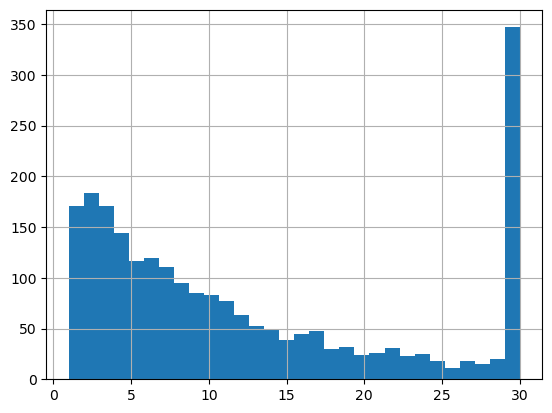

In [81]:
filtered_similarity_edge['source_id'].value_counts().hist(bins=30)

In [82]:
filtered_similarity_edge[['source_id','target_id','weight']].to_csv("../data/processed/similarTo_edge_processed.csv", index=False)